# Advanced Model Architectures
> It's time to get introduced to more advanced architectures! You will create an autoencoder to reconstruct noisy images, visualize convolutional neural network activations, use deep pre-trained models to classify images and learn more about recurrent neural networks and working with text as you build a network that predicts the next word in a sentence. This is the Summary of lecture "Introduction to Deep Learning with Keras", via datacamp.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Tensorflow-Keras, Deep_Learning]
- image: 

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 8)

### Tensors, layers, and autoencoders
- Tensors
    - main data structures used in deep learning.
    - Inputs/Outputs and transformations in neural networks are all presented using tensors
- Autoencoders
![ae](image/ae.png)
    - Use cases
        - Dimensionality reduction:
            - Smaller dimensional space representation of our inputs
        - De-noising data:
            - If trained with clean data, irrelevant noise will be filtered out during reconstruction
        - Anormaly detection
            - A poor reconstruction will result when the model is fed with unseen inputs

### It's a flow of tensors
If you have already built a model, you can use the `model.layers` and the `tf.keras.backend` to build functions that, provided with a valid input tensor, return the corresponding output tensor.

This is a useful tool when we want to obtain the output of a network at an intermediate layer.

For instance, if you get the input and output from the first layer of a network, you can build an `inp_to_out` function that returns the result of carrying out forward propagation through only the first layer for a given input tensor.

So that's what you're going to do right now!

In [2]:
banknote = pd.read_csv('./dataset/banknotes.csv')
banknote.head()

,variace,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
from sklearn.model_selection import train_test_split

X = banknote.drop(['class'], axis=1)
# Normalize data
X = ((X - X.mean()) / X.std()).to_numpy()
y = banknote['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(2, input_shape=(4, ), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [5]:
import tensorflow.keras.backend as K

# Input tensor from the 1st layer of the model
inp = model.layers[0].input

# Output tensor from the 1st layer of the model
out = model.layers[0].output

# Define a function from inputs to outputs
inp_to_out = K.function([inp], [out])

# Print the results of passing X_test through the 1st layer
print(inp_to_out([X_test]))

[array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 7.48464108e-01],
       [1.22207038e-01, 3.83201152e-01],
       [1.19923997e+00, 0.00000000e+00],
       [2.98763454e-01, 1.94569677e-01],
       [2.13709012e-01, 0.00000000e+00],
       [1.32162678e+00, 4.84023869e-01],
       [6.83276415e-01, 1.45424163e+00],
       [5.06092072e-01, 8.46279204e-01],
       [0.00000000e+00, 0.00000000e+00],
       [3.88836622e-01, 0.00000000e+00],
       [1.49042571e+00, 5.18140256e-01],
       [4.63232785e-01, 0.00000000e+00],
       [0.00000000e+00, 1.73765552e+00],
       [2.07145381e+00, 1.54450452e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.10999504e-01],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.47916150e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 6.34284973e-01],
       [0.00000000e+00, 0.00000000e+00],
       [1.82211

### Neural separation
Put on your gloves because you're going to perform brain surgery!

Neurons learn by updating their weights to output values that help them better distinguish between the different output classes in your dataset. You will make use of the `inp_to_out()` function you just built to visualize the output of two neurons in the first layer of the Banknote Authentication `model` as it learns.

In [6]:
def plot():
    fig, axes = plt.subplots(1, 5, figsize=(16, 8))
    for i, a in enumerate(axes):
        a.scatter(layer_outputs[i][:, 0], layer_outputs[i][:, 1], c=y_test, edgecolors='none');
        a.set_title('Test Accuracy: {:3.1f} %'.format(float(test_accuracies[i]) * 100.));
    plt.tight_layout()

In [7]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
layer_outputs = []
test_accuracies = []

for i in range(0, 21):
    # Train model for 1 epoch
    h = model.fit(X_train, y_train, batch_size=16, epochs=1, verbose=0)
    if i % 4 == 0:
        # Get the output of the first layer
        layer_outputs.append(inp_to_out([X_test])[0])
        
        # Evaluate model accuracy for this epoch
        test_accuracies.append(model.evaluate(X_test, y_test)[1])

13/13 [==============================] - 0s 808us/step - loss: 0.2989 - accuracy: 0.9515


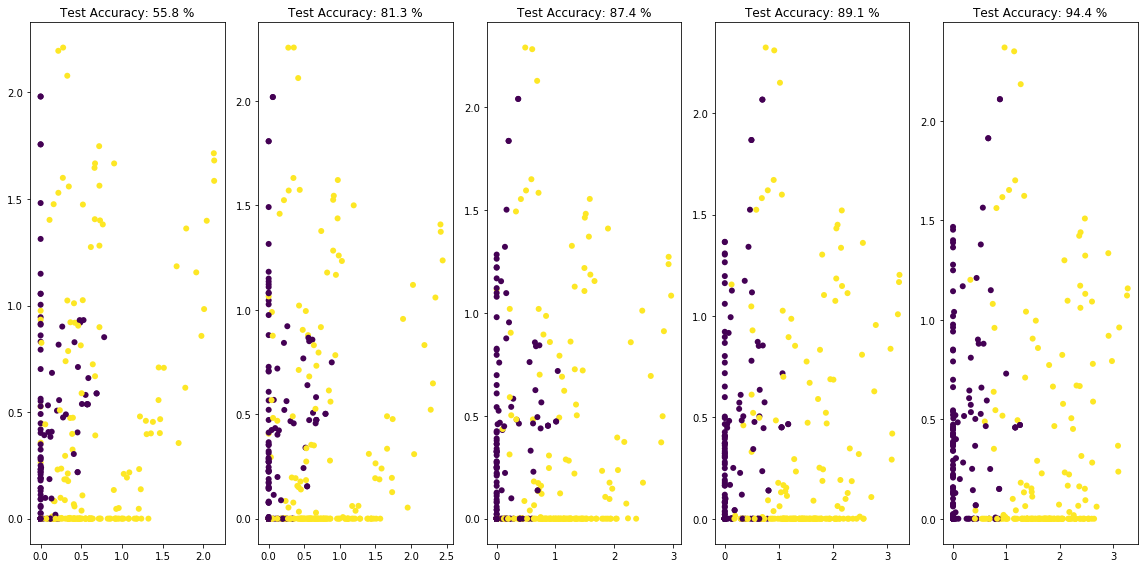

In [9]:
# Plot 1st vs 2nd neuron output
plot()

That took a while! If you take a look at the graphs you can see how the neurons are learning to spread out the inputs based on whether they are fake or legit dollar bills. (A single fake dollar bill is represented as a purple dot in the graph) At the start the outputs are closer to each other, the weights are learned as epochs go by so that fake and legit dollar bills get a different, further and further apart output.

### Building an autoencoder
Autoencoders have several interesting applications like anomaly detection or image denoising. They aim at producing an output identical to its inputs. The input will be compressed into a lower dimensional space, encoded. The model then learns to decode it back to its original form.

You will encode and decode the MNIST dataset of handwritten digits, the hidden layer will encode a 32-dimensional representation of the image, which originally consists of 784 pixels (28 x 28). The autoencoder will essentially learn to turn the 784 pixels original image into a compressed 32 pixels image and learn how to use that encoded representation to bring back the original 784 pixels image.

In [27]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype(np.float32) / 255.
X_test = X_test.astype(np.float32) / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [28]:
# Start with a sequential model
autoencoder = Sequential(name='autoencoder')

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(32, input_shape=(784, ), activation='relu'))

# Add an output layer with as many neurons as the original image pixels
autoencoder.add(Dense(784, activation='sigmoid'))

# Compile your model with adadelta
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# Summarize your model structure
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_13 (Dense)             (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


### De-noising like an autoencoder
Okay, you have just built an `autoencoder` model. Let's see how it handles a more challenging task.

First, you will build a model that encodes images, and you will check how different digits are represented with `show_encodings()`. To build the encoder you will make use of your autoencoder, that has already being trained. You will just use the first half of the network, which contains the input and the bottleneck output. That way, you will obtain a 32 number output which represents the encoded version of the input image.

Then, you will apply your autoencoder to noisy images from MNIST, it should be able to clean the noisy artifacts.

The digits in this noisy dataset look like this:
![noise](image/noisy_mnist_sample.png)

In [35]:
def show_encodings(encoded_imgs,number=1):
    n = 5  # how many digits we will display
    original = X_test
    original = original[np.where(y_test == number)]
    encoded_imgs = encoded_imgs[np.where(y_test==number)]
    plt.figure(figsize=(20, 4))
    #plt.title('Original '+str(number)+' vs Encoded representation')
    for i in range(min(n,len(original))):
        # display original imgs
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoded imgs
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.tile(encoded_imgs[i],(32,1)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

def compare_plot(original,decoded_imgs):
    n = 4  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title('Noisy vs Decoded images')

In [52]:
# Train autoencoder
autoencoder.fit(X_train, X_train,
                epochs=1000,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test), verbose=1);

Epoch 1/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2672 - val_loss: 0.2664
Epoch 2/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2672 - val_loss: 0.2664
Epoch 3/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2672 - val_loss: 0.2664
Epoch 4/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2672 - val_loss: 0.2663
Epoch 5/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2671 - val_loss: 0.2663
Epoch 6/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2671 - val_loss: 0.2663
Epoch 7/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2671 - val_loss: 0.2663
Epoch 8/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2671 - val_loss: 0.2663
Epoch 9/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2671 - val_loss: 0.2663
Epoch 10/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.267

235/235 [==============================] - 0s 2ms/step - loss: 0.2662 - val_loss: 0.2653
Epoch 81/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2662 - val_loss: 0.2653
Epoch 82/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2661 - val_loss: 0.2653
Epoch 83/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2661 - val_loss: 0.2653
Epoch 84/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2661 - val_loss: 0.2653
Epoch 85/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2661 - val_loss: 0.2653
Epoch 86/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2661 - val_loss: 0.2653
Epoch 87/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2661 - val_loss: 0.2653
Epoch 88/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2661 - val_loss: 0.2652
Epoch 89/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2660 - v

235/235 [==============================] - 0s 2ms/step - loss: 0.2651 - val_loss: 0.2643
Epoch 159/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2651 - val_loss: 0.2643
Epoch 160/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2651 - val_loss: 0.2642
Epoch 161/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2651 - val_loss: 0.2642
Epoch 162/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2650 - val_loss: 0.2642
Epoch 163/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2650 - val_loss: 0.2642
Epoch 164/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2650 - val_loss: 0.2642
Epoch 165/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2650 - val_loss: 0.2642
Epoch 166/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2650 - val_loss: 0.2642
Epoch 167/1000
235/235 [==============================] - 0s 2ms/step - loss: 0

Epoch 237/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2640 - val_loss: 0.2631
Epoch 238/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2639 - val_loss: 0.2631
Epoch 239/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2639 - val_loss: 0.2631
Epoch 240/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2639 - val_loss: 0.2631
Epoch 241/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2639 - val_loss: 0.2631
Epoch 242/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2639 - val_loss: 0.2630
Epoch 243/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2639 - val_loss: 0.2630
Epoch 244/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2639 - val_loss: 0.2630
Epoch 245/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2638 - val_loss: 0.2630
Epoch 246/1000
235/235 [==============================] - 0s 2ms

Epoch 316/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2628 - val_loss: 0.2619
Epoch 317/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2627 - val_loss: 0.2619
Epoch 318/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2627 - val_loss: 0.2618
Epoch 319/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2627 - val_loss: 0.2618
Epoch 320/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2627 - val_loss: 0.2618
Epoch 321/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2627 - val_loss: 0.2618
Epoch 322/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2627 - val_loss: 0.2618
Epoch 323/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2626 - val_loss: 0.2618
Epoch 324/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2626 - val_loss: 0.2618
Epoch 325/1000
235/235 [==============================] - 0s 2ms

Epoch 395/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2615 - val_loss: 0.2606
Epoch 396/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2615 - val_loss: 0.2606
Epoch 397/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2614 - val_loss: 0.2605
Epoch 398/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2614 - val_loss: 0.2605
Epoch 399/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2614 - val_loss: 0.2605
Epoch 400/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2614 - val_loss: 0.2605
Epoch 401/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2614 - val_loss: 0.2605
Epoch 402/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2614 - val_loss: 0.2605
Epoch 403/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2613 - val_loss: 0.2604
Epoch 404/1000
235/235 [==============================] - 0s 2ms

Epoch 474/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2601 - val_loss: 0.2592
Epoch 475/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2601 - val_loss: 0.2592
Epoch 476/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2601 - val_loss: 0.2592
Epoch 477/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2601 - val_loss: 0.2591
Epoch 478/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2600 - val_loss: 0.2591
Epoch 479/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2600 - val_loss: 0.2591
Epoch 480/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2600 - val_loss: 0.2591
Epoch 481/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2600 - val_loss: 0.2591
Epoch 482/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2600 - val_loss: 0.2590
Epoch 483/1000
235/235 [==============================] - 0s 2ms

Epoch 553/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2587 - val_loss: 0.2577
Epoch 554/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2587 - val_loss: 0.2577
Epoch 555/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2587 - val_loss: 0.2577
Epoch 556/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2586 - val_loss: 0.2577
Epoch 557/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2586 - val_loss: 0.2577
Epoch 558/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2586 - val_loss: 0.2576
Epoch 559/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2586 - val_loss: 0.2576
Epoch 560/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2586 - val_loss: 0.2576
Epoch 561/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2585 - val_loss: 0.2576
Epoch 562/1000
235/235 [==============================] - 0s 2ms

Epoch 632/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2572 - val_loss: 0.2562
Epoch 633/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2572 - val_loss: 0.2562
Epoch 634/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2571 - val_loss: 0.2562
Epoch 635/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2571 - val_loss: 0.2561
Epoch 636/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2571 - val_loss: 0.2561
Epoch 637/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2571 - val_loss: 0.2561
Epoch 638/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2571 - val_loss: 0.2561
Epoch 639/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2571 - val_loss: 0.2561
Epoch 640/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2570 - val_loss: 0.2560
Epoch 641/1000
235/235 [==============================] - 0s 2ms

Epoch 711/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2556 - val_loss: 0.2546
Epoch 712/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2556 - val_loss: 0.2546
Epoch 713/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2556 - val_loss: 0.2546
Epoch 714/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2556 - val_loss: 0.2545
Epoch 715/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2555 - val_loss: 0.2545
Epoch 716/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2555 - val_loss: 0.2545
Epoch 717/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2555 - val_loss: 0.2545
Epoch 718/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2555 - val_loss: 0.2544
Epoch 719/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2555 - val_loss: 0.2544
Epoch 720/1000
235/235 [==============================] - 0s 2ms

235/235 [==============================] - 0s 2ms/step - loss: 0.2540 - val_loss: 0.2530
Epoch 790/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2540 - val_loss: 0.2529
Epoch 791/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2540 - val_loss: 0.2529
Epoch 792/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2540 - val_loss: 0.2529
Epoch 793/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2539 - val_loss: 0.2529
Epoch 794/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2539 - val_loss: 0.2528
Epoch 795/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2539 - val_loss: 0.2528
Epoch 796/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2539 - val_loss: 0.2528
Epoch 797/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2538 - val_loss: 0.2528
Epoch 798/1000
235/235 [==============================] - 0s 2ms/step - loss: 0

Epoch 868/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2523 - val_loss: 0.2512
Epoch 869/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2523 - val_loss: 0.2512
Epoch 870/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2523 - val_loss: 0.2512
Epoch 871/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2523 - val_loss: 0.2512
Epoch 872/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2523 - val_loss: 0.2512
Epoch 873/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2522 - val_loss: 0.2511
Epoch 874/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2522 - val_loss: 0.2511
Epoch 875/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2522 - val_loss: 0.2511
Epoch 876/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2522 - val_loss: 0.2511
Epoch 877/1000
235/235 [==============================] - 0s 2ms

235/235 [==============================] - 0s 2ms/step - loss: 0.2507 - val_loss: 0.2495
Epoch 947/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2506 - val_loss: 0.2495
Epoch 948/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2506 - val_loss: 0.2495
Epoch 949/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2506 - val_loss: 0.2494
Epoch 950/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2506 - val_loss: 0.2494
Epoch 951/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2505 - val_loss: 0.2494
Epoch 952/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2505 - val_loss: 0.2494
Epoch 953/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2505 - val_loss: 0.2494
Epoch 954/1000
235/235 [==============================] - 0s 2ms/step - loss: 0.2505 - val_loss: 0.2493
Epoch 955/1000
235/235 [==============================] - 0s 2ms/step - loss: 0

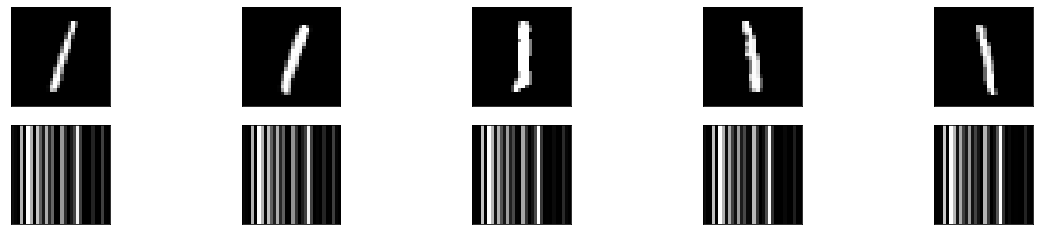

In [53]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(X_test)
# encodings
show_encodings(encodings, number=1)

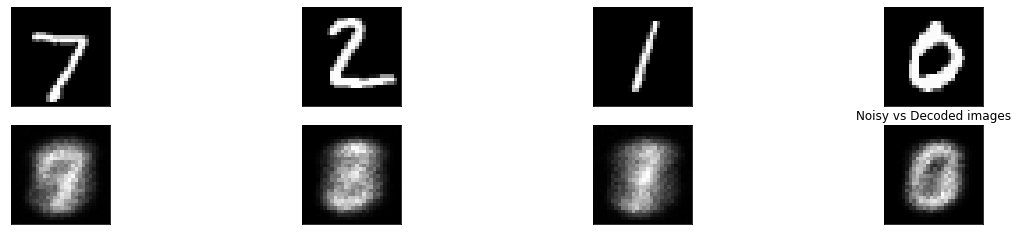

In [54]:
# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(X_test)

# Plot noisy vs decoded images
compare_plot(X_test, decoded_imgs)

Amazing! The noise is gone now! You could get a better reconstruction by using a convolutional autoencoder. I hope this new model opened up your mind to the many possible architectures and non-classical ML problems that neural networks can solve :)